# Tabular classification with Amazon SageMaker TabTransformer algorithm

## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import sagemaker, boto3, json
from sagemaker import get_execution_role

## First, we store the training and validation data in S3 as instructed by AWS

In [4]:
# include all paths to data from local storage location
TRAIN_DATA = os.environ['DATAFILES_PATH'] + '/ICR_Competition/' + 'train.csv'
TEST_DATA = os.environ['DATAFILES_PATH'] + '/ICR_Competition/' + 'test.csv'
GREEKS_DATA = os.environ['DATAFILES_PATH'] + '/ICR_Competition/' + 'greeks.csv'

# load training data
train_df = pd.read_csv(TRAIN_DATA)

# allocate
X = train_df.drop(columns=['Class', 'Id'])
X = pd.get_dummies(X, drop_first=True)

y = train_df['Class'].astype(int)

# train-validation split 
X_train_raw, X_val, y_train_raw, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

X_val['EJ_B'].fillna(value=X_train_raw['EJ_B'].mode())
X_val = X_val.fillna(value=X_train_raw.mean())

X_train_raw['EJ_B'].fillna(value=X_train_raw['EJ_B'].mode())
X_train_raw = X_train_raw.fillna(value=X_train_raw.mean())

# over sample the diagnosed patients in training set
oversample = SMOTE(random_state=77, sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train_raw, y_train_raw)

# shuffle (in case the model choice may be impacted by ordering)
np.random.seed(77)
shuff_ind = np.random.choice(len(y_train), len(y_train), replace=False)

X_train = X_train.iloc[shuff_ind,]
y_train = y_train.iloc[shuff_ind,]

# create df for train and val as instructed by aws
df_train = pd.concat([y_train, X_train], axis=1)
df_train = df_train.dropna()

df_val = pd.concat([y_val, X_val], axis=1)
df_val = df_val.dropna()

if not os.path.exists('train'):
    os.mkdir('train')

df_train.to_csv('train/data.csv', index=False, header=False)

if not os.path.exists('validation'):
    os.mkdir('validation')

df_val.to_csv('validation/data.csv', index=False, header=False)


# Upload the files to s3
s3 = boto3.resource('s3')
response = s3.meta.client.upload_file('train/data.csv', 
                                      'mypersonalprojectdata', 
                                      'ICR-Data/train/data.csv')

response = s3.meta.client.upload_file('validation/data.csv', 
                                      'mypersonalprojectdata', 
                                      'ICR-Data/validation/data.csv')


# remove files and directories locally
os.remove('train/data.csv')
os.remove('validation/data.csv')
os.rmdir('train')
os.rmdir('validation')

## Next, we set up a SageMaker training session

In [3]:
sess = sagemaker.Session(boto3.session.Session(region_name='us-west-1'))
aws_region = boto3.Session().region_name
aws_role = 'arn:aws:iam::378421839225:role/service-role/AmazonSageMaker-ExecutionRole-20230623T185897'

In [5]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = (
    "pytorch-tabtransformerclassification-model",
    "*",
    "training",
)
training_instance_type = "ml.m5.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=aws_region,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune. In tabular case, however, the pre-trained model tarball is dummy and fine-tune means training from scratch.
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

### Set Training Parameters

---

Now that we are done with all the setup that is needed, we are ready to train our tabular algorithm. To begin, we create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training.

The second set of parameters are model, or algorithm, specific training hyperparameters. 

---

In [6]:
# Sample training data is available in this bucket
data_bucket = "mypersonalprojectdata"
training_data_prefix = "ICR-Data/train"
validation_data_prefix = "ICR-Data/validation"

training_dataset_s3_path = f"s3://{data_bucket}/{training_data_prefix}"
validation_dataset_s3_path = f"s3://{data_bucket}/{validation_data_prefix}"


output_bucket = sess.default_bucket()
output_prefix = "tabular-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

---

For the model specific specific hyperparameters, we start by fetching a python dictionary of the training hyperparameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [7]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# Override the number of epochs hyperparameter with custom values
hyperparameters["n_epochs"] = "15"
print(hyperparameters)

{'n_epochs': '15', 'patience': '10', 'learning_rate': '0.001', 'batch_size': '256', 'input_dim': '32', 'n_blocks': '4', 'attn_dropout': '0.2', 'mlp_dropout': '0.1', 'frac_shared_embed': '0.25'}


# We move on to train with automatic model tuning  

We use a HyperparameterTuner object to interact with Amazon SageMaker hyperparameter tuning APIs.

In [8]:
from sagemaker.tuner import ContinuousParameter, CategoricalParameter, HyperparameterTuner

use_amt = True

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.01, scaling_type="Auto"),
    "batch_size": CategoricalParameter([128, 256, 512]),
    "attn_dropout": ContinuousParameter(0.0, 0.8, scaling_type="Auto"),
    "mlp_dropout": ContinuousParameter(0.0, 0.8, scaling_type="Auto"),
}

---
We start by creating the estimator object with all the required assets and then launch the training job.

---

In [9]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=1200,
    max_retry_attempts=3,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

In [10]:
# tune hyper-parameters with instances in AWS
tuner = HyperparameterTuner(
    tabular_estimator,
    "f1_score",
    hyperparameter_ranges,
    [{"Name": "f1_score", "Regex": "metrics={'f1': (\\S+)}"}],
    max_jobs=10,  # increase the max_jobs to achieve better performance from hyperparameter tuning
    max_parallel_jobs=5,
    objective_type="Maximize",
    base_tuning_job_name=training_job_name,
)

tuner.fit({"training": training_dataset_s3_path, "validation": validation_dataset_s3_path}, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................!


In [11]:
print(f'The best training job: {tuner.best_training_job()}')

The best training job: jumpstart-pytorch-ta-230729-1203-001-4d9f2ac5


The "best" hyperparameters can be seen on the AWS console. The following is from the best training job (001) with the highest `f1_score` of 0.8461999893188477:

- `attn_dropout=0.1366675096371158`
- `batch_size=128`
- `frac_shared_embed="0.25"`
- `input_dim="32"`
- `learning_rate=0.002492988535620627`
- `mlp_dropout=0.49012177472333396`
- `n_blocks="4"`
- `n_epochs="15"`
- `patience="10"`
- `sagemaker_container_log_level=20`

We now deploy and run inference on the trained TabTransformer model for the ICR validation data to store the predictions to use in other ensemble models.

---

The model will output the probability of the sample for each class in the model (2 classes). We start by retrieving the jumpstart artifacts and deploying the `tuner` that we trained.

---

In [12]:
inference_instance_type = "ml.m5.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=aws_region,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-inference-{train_model_id}")

# Use estimator with best hyperparameters from the previous step to deploy to a SageMaker endpoint
predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)


2023-07-29 19:07:53 Starting - Preparing the instances for training
2023-07-29 19:07:53 Downloading - Downloading input data
2023-07-29 19:07:53 Training - Training image download completed. Training in progress.
2023-07-29 19:07:53 Uploading - Uploading generated training model
2023-07-29 19:07:53 Completed - Resource reused by training job: jumpstart-pytorch-ta-230729-1203-007-1b94610a
-----!

In [14]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# set up training data for predictions
df_train.columns = ["Target"] + [f"Feature_{i}" for i in range(1, df_train.shape[1])]

num_examples_train, num_columns_train = df_train.shape

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label_train, features_train = df_train.iloc[:, :1], df_train.iloc[:, 1:]


# set up validation data for predictions
df_val.columns = ["Target"] + [f"Feature_{i}" for i in range(1, df_val.shape[1])]

num_examples, num_columns = df_val.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = df_val.iloc[:, :1], df_val.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
df_val.head(5)

The test dataset contains 124 examples and 57 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,Feature_55,Feature_56
49,1,0.478576,5192.25520,194.576478,13.230384,8.138688,7.290957,0.025578,9.705080,8.588216,...,10.690335,1.85861,0.067730,12.418170,72.611063,434.357883,34.411808,36.769312,0.050038,1
581,0,1.096024,4348.11080,546.489750,72.469800,8.138688,3.167092,0.102921,3.396778,13.381312,...,5.760795,2.02884,0.182871,12.283291,72.611063,2184.856740,33.204344,40.169496,0.077344,1
82,0,0.307656,3039.47402,85.200147,14.534221,8.715528,5.262246,0.031668,11.665002,1.229900,...,0.173229,0.49706,0.067730,7.534620,139.519779,10093.114350,30.456385,56.463116,21.978000,0
304,1,0.948606,6192.61907,99.857394,29.179934,8.138688,3.632190,0.025578,7.404850,7.920556,...,5.014797,1.04371,1.666158,17.264512,72.611063,3595.331772,35.583923,36.584128,0.131416,1
109,1,1.307538,8922.64648,198.478110,123.582688,13.380066,9.231078,0.025578,16.404106,28.561792,...,6.015965,0.71224,0.331877,10.101972,72.611063,4973.463261,46.062259,47.428966,0.027720,1


---
The following code queries the endpoint we have created to get the predictions for the validation data. 
The `query_endpoint()` function returns an array-like of shape `(num_examples, num_classes)`, where each row indicates
the probability of each class in the model. The `num_classes` is 2 in above test data.
In addition, the predicted class label is obtained by taking the class label with the maximum probability over others for each example. 

---

In [16]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    # endpoint_name = endpoint_name
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions["probabilities"]
    return np.array(predicted_probabilities)

# split the train data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predict_prob_train = []
for i in np.arange(0, num_examples_train, step=batch_size):
    query_response_batch = query_endpoint(
        features_train.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob_train.append(predict_prob_batch)


predict_prob_train = np.concatenate(predict_prob_train, axis=0)

# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(predict_prob, axis=1)

## Evaluate the Validation Results Returned from the Endpoint

---
We evaluate the predictions returned from the endpoint by following two ways.

* Visualize the predictions results by plotting the confusion matrix.

* Evaluate the balanced logarithmic loss (as evaluated in the ICR -- Kaggle competition), along with a few other performance metrics.

---

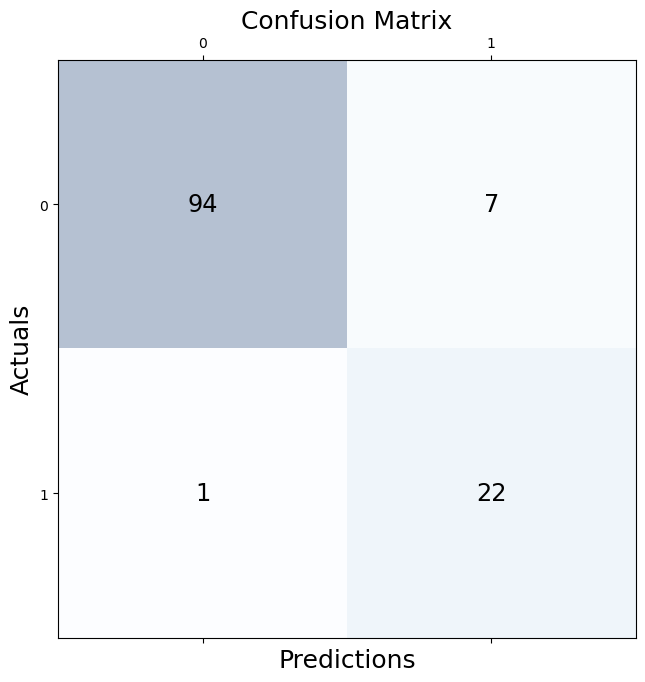

In [17]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [18]:
def bal_log_loss(p, y):
    ind0 = np.where(y==0)[0]
    ind1 = np.where(y==1)[0]
    
    N0 = len(ind0)
    N1 = len(ind1)
    
    y0 = (y==0).astype(int)
    y1 = y.astype(int)
    
    return (- np.sum(y0*np.log(p[:, 0]))/N0 - np.sum(y1*np.log(p[:, 1]))/N1) / 2


# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1 = f1_score(ground_truth_label.values, predict_label)
eval_log_loss = bal_log_loss(predict_prob, np.squeeze(ground_truth_label.values, axis=(1,)))

print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}F1 {unbold}: {eval_f1}{newline}"
    f"{bold}Log-Loss {unbold}: {eval_log_loss}{newline}"
)

# store the training-set predictions in csv format, locally.
pd.DataFrame(predict_prob_train).to_csv("train_pred_probs/amzn-tab-trans.csv", header=True, index=False)

# store the validation-set predictions in csv format, locally.
pd.DataFrame(predict_prob).to_csv("val_pred_probs/amzn-tab-trans.csv", header=True, index=False)


Evaluation result on test data:
accuracy_score: 0.9354838709677419
F1 : 0.8461538461538461
Log-Loss : 0.13024372461774888



---
Next, we delete the endpoint corresponding to the trained model.

---

In [19]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()

# Predictions for Test Set Submission


------


Using the reported hyperparameters for *jumpstart-pytorch-ta-230701-1231-003-c17981ed*, we retrain the estimator with all of the training data. Since our training data is already fairly small, this is done to not waste the relatively training data. 

First, we reorganize the training data such that the entire set of data is used to train and only the training data is considered during "validation". 

------

In [20]:
# load training data
train_df = pd.read_csv(TRAIN_DATA)

# allocate
X = train_df.drop(columns=['Class', 'Id'])
X = pd.get_dummies(X, drop_first=True)

# fill NaNs
X['EJ_B'].fillna(value=X['EJ_B'].mode())
X = X.fillna(value=X.mean())

y = train_df['Class'].astype(int)

# over sample the diagnosed patients in training set
oversample = SMOTE(random_state=77, sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X, y)

# shuffle (in case the model choice may be impacted by ordering)
shuff_ind = np.random.choice(len(y_train), len(y_train), replace=False)

X_train = X_train.iloc[shuff_ind,]
y_train = y_train.iloc[shuff_ind,]

# create df for train and val (should be the same in this case)
df_train = pd.concat([y_train, X_train], axis=1)
df_train = df_train.dropna()

df_val = pd.concat([y_train, X_train], axis=1)

df_val = df_val.dropna()

if not os.path.exists('train'):
    os.mkdir('train')

df_train.to_csv('train/data.csv', index=False, header=False)

if not os.path.exists('validation'):
    os.mkdir('validation')

df_val.to_csv('validation/data.csv', index=False, header=False)


# Upload the files to s3
s3 = boto3.resource('s3')
response = s3.meta.client.upload_file('train/data.csv', 
                                      'mypersonalprojectdata', 
                                      'ICR-Data/train/data.csv')

response = s3.meta.client.upload_file('validation/data.csv', 
                                      'mypersonalprojectdata', 
                                      'ICR-Data/validation/data.csv')


# remove files and directories locally
os.remove('train/data.csv')
os.remove('validation/data.csv')
os.rmdir('train')
os.rmdir('validation')


Now we begin training with all of the available data, using the previously found "optimal" hyperparameters from tuning.

In [21]:
from sagemaker import hyperparameters
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-{train_model_id}-training")

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)


# Override the number of epochs hyperparameter with custom values

hyperparameters['n_epochs'] = "15"
hyperparameters['learning_rate'] = 0.002492988535620627
hyperparameters['batch_size'] = 128
hyperparameters['attn_dropout'] = 0.1366675096371158
hyperparameters['mlp_dropout'] = 0.49012177472333396


# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator.fit(
    {"training": training_dataset_s3_path, "validation": validation_dataset_s3_path}, 
    logs=True, job_name=training_job_name
)

INFO:sagemaker:Creating training-job with name: jumpstart-pytorch-tabtransformerclassif-2023-07-29-19-34-53-229


2023-07-29 19:34:55 Starting - Starting the training job...
2023-07-29 19:35:09 Starting - Preparing the instances for training......
2023-07-29 19:36:23 Downloading - Downloading input data
2023-07-29 19:36:23 Training - Downloading the training image...
2023-07-29 19:36:45 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-29 19:37:03,742 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-29 19:37:03,744 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-29 19:37:03,753 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-29 19:37:03,755 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-07-29 19:37:05,316 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/

2023-07-29 19:37:18,261 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-29 19:37:18,272 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-29 19:37:18,282 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-29 19:37:18,291 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "model": "/opt/ml/input/data/model",
        "training": "/opt/ml/input/data/training",
        "validation": "/opt/ml/input/data/validation"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_pytorch_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "attn_dropout": 0.1366675096371158,
        "batch_size": 128,
        "frac_shared_embed": "0.25",
        "input_dim": "32",
        "learning_rate": 0.002492988535620627,
        "

epoch 3:  25%|██▌       | 2/8 [00:01<00:05,  1.19it/s, loss=0.593, metrics={'f1': 0.661}]


epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]


epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]


epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]


epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]


0%|          | 0/8 [00:00<?, ?it/s]


valid: 100%|██████████| 8/8 [00:00<00:00,  8.36it/s, loss=0.0896, metrics={'f1': 0.9527}]
INFO:root:Training is completed.
INFO:root:Saving model...
2023-07-29 19:38:41,124 sagemaker-training-toolkit INFO     Reporting training SUCCESS



2023-07-29 19:39:01 Uploading - Uploading generated training model
2023-07-29 19:39:01 Completed - Training job completed
Training seconds: 178
Billable seconds: 178


As we did before, we deploy a model for inference and then generate predictions for the test set.

In [22]:
inference_instance_type = "ml.m5.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=aws_region,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-inference-{train_model_id}")

# Use estimator with best hyperparameters from the previous step to deploy to a SageMaker endpoint
predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)



INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-west-1-378421839225/tabular-training/output/jumpstart-pytorch-tabtransformerclassif-2023-07-29-19-34-53-229/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-us-west-1/source-directory-tarballs/pytorch/inference/tabtransformerclassification/v1.0.2/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-west-1-378421839225/sagemaker-jumpstart-2023-07-29-19-42-26-705/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-07-29-19-42-26-705
INFO:sagemaker:Creating endpoint-config with name jumpstart-inference-pytorch-tabtransfor-2023-07-29-19-42-26-705
INFO:sagemaker:Creating endpoint with name jumpstart-inference-pytorch-tabtransfor-2023-07-29-19-42-26-705


-----!

In [23]:
# load testing data
test_df = pd.read_csv(TEST_DATA)
test_df['EJ_B'] = (test_df['EJ'] == 'B').astype('int')
X_test = test_df.drop(columns=['Id', 'EJ'])

df_test = pd.concat([X_test], axis=1)
df_test.columns = [f"Feature_{i}" for i in range(df_test.shape[1])]

# prepare the predicting features to send into the endpoint.
features = df_test.iloc[:, :]

# make predictions
query_response_batch = query_endpoint(
    features.iloc[:, :].to_csv(header=False, index=False).encode("utf-8")
)

predict_prob = parse_response(query_response_batch)  # prediction probability per batch
predict_label = np.argmax(predict_prob, axis=1)

# store the test-set predictions in csv format, locally.
pd.DataFrame(predict_prob).to_csv("test_pred_probs/amzn-tab-trans.csv", header=True, index=False)

In [24]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2023-07-29-19-42-26-705
INFO:sagemaker:Deleting endpoint configuration with name: jumpstart-inference-pytorch-tabtransfor-2023-07-29-19-42-26-705
INFO:sagemaker:Deleting endpoint with name: jumpstart-inference-pytorch-tabtransfor-2023-07-29-19-42-26-705
